# Predicting Whether a Breast Cancer Sample is Benign or Malignant

## Learning Objectives:


1. Understand what SageMaker Script Mode is, and how it can be leveraged.
1. Read in data from S3 to SageMaker.
1. Use SageManer Data Wrangler data for feature engineering.
1. Use prebuilt SageMaker containers to build, train, and deploy customer sklearn model.
1. Use batch transform to perform inferences and measure model performance.


## Introduction
This is a breast cancer diagnoses dataset, where, for each sample, the sample is diagnosed as "Benign" or "Malignant". For each sample, a number of features are given as well. The source of the dataset is the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)).

For this model, we will build, train and deploy a [Multi-layer Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) using the sklearn library.

To prepare data, we are going to use [SageMaker Data Wrangler](https://aws.amazon.com/sagemaker/data-wrangler/)

## Contents

1. [Setup](#Setup)
1. [Process Data](#Process-Data)
    1. [Copy dataset (if your SM domain not in us-east-1)](#Copy-dataset-(if-your-SM-domain-not-in-us-east-1))
    1. [Option 1. Create a workflow using Data Wrangler](#Option-1.-Create-a-workflow-using-Data-Wrangler)
    1. [Option 2. Use existing Data Wrangler workflow](#Option-2.-Use-existing-Data-Wrangler-workflow)
    1. [Export to run as a SageMaker Pipeline](#Export-to-run-as-a-SageMaker-Pipeline)
    1. [Run Processing job](#Run-Processing-job)
    1. [Prepare data for training and testing](#Prepare-data-for-training-and-testing)
1. [Train the Model](#Train-the-Model)
1. [Make Batch Predictions](#Make-Batch-Predictions)

## Setup

In [2]:
# Ensure we have the right version of sagemaker
%pip install sagemaker==2.72.3

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
  Using cached sagemaker-2.72.3-py2.py3-none-any.whl
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.70.0
    Uninstalling sagemaker-2.70.0:
      Successfully uninstalled sagemaker-2.70.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import required libraries and create necessary clients
import boto3
import matplotlib.pyplot as plt
import pandas
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.s3 import S3Downloader, S3Uploader
from sklearn import model_selection
import sklearn.metrics as metrics

import json
from urllib.parse import urlparse

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()

s3_client = boto3.client("s3")
sagemaker_client = boto3.client('sagemaker')

In [4]:
# Initialize variables
BUCKET = sagemaker_session.default_bucket()
PREFIX = "breast_cancer"
PREFIX_RAW = PREFIX + '/raw'
PREFIX_PROCESSED = PREFIX + '/processed'

# Initialize dataset URL
original_s3_dataset_url = 's3://sagemaker-sample-files/datasets/tabular/breast_cancer/wdbc.csv'
original_s3_dataset_region = 'us-east-1'

# Default Data Wrangler flow file
hcls_lab_flow_file = 'hcls-lab.flow'

## Process Data

### Copy dataset (if your SM domain not in us-east-1)

In [5]:
region = boto3.Session().region_name

s3_dataset_url = ''

if region != original_s3_dataset_region:
    s3_dataset_path = original_s3_dataset_url[4:]
    s3_dataset_filename = original_s3_dataset_url.split('/')[-1]

    response = s3_client.copy_object(
        Bucket=BUCKET,
        CopySource=s3_dataset_path,
        Key=f'{PREFIX_RAW}/{s3_dataset_filename}',
    )
    
    s3_dataset_url = f's3://{BUCKET}/{PREFIX_RAW}/{s3_dataset_filename}'
    print(f'Copied public dataset to private bucket in region={region}:')
else:
    s3_dataset_url = original_s3_dataset_url
    print(f'S3 bucket of dataset matches SageMaker domain region={region} and can be used as is:')
    
print(s3_dataset_url)

Copied public dataset to private bucket in region=us-west-2:
s3://sagemaker-us-west-2-321600923601/breast_cancer/raw/wdbc.csv


### Option 1. Create a workflow using Data Wrangler

You can follow steps below to create a Data Wrangler flow. Or you skip these steps and use existing flow by following [Option 2. Use existing Data Wrangler workflow](#Option-2.-Use-existing-Data-Wrangler-workflow).

#### 1. Create new Data Wrangler flow

![Create Flow](./images/dw_create_flow.png "Create Flow")

Rename flow. You can choose any name, for example `hcsl-lab-2022`.

![Rename Flow](./images/dw_rename_flow.png "Rename Flow")

#### 2. Configure data import from S3

![S3 Import](./images/dw_import_s3.png "S3 Import")

Configure and start S3 Import.

![Configure and start S3 Import](./images/dw_import_s3_start.png "Configure and start S3 Import")

#### 3. Add Transformations

!["Add Transform"](./images/dw_transform.png "Add Transform")

Add New Transformation.

!["Add New Transform"](./images/dw_transform_add.png "Add New Transform")

Add Custom transformation to add columns names.

!["Add Transform - Custom"](./images/dw_transform_custom.png "Add Transform - Custom")

Select Pandas:

!["Add Transform - Custom Pandas"](./images/dw_transform_pandas.png "Add Transform - Custom Pandas")

And paste this code:

```python
column_names=[
        "id",
        "diagnosis",
        "radius_mean",
        "texture_mean",
        "perimeter_mean",
        "area_mean",
        "smoothness_mean",
        "compactness_mean",
        "concavity_mean",
        "concave points_mean",
        "symmetry_mean",
        "fractal_dimension_mean",
        "radius_se",
        "texture_se",
        "perimeter_se",
        "area_se",
        "smoothness_se",
        "compactness_se",
        "concavity_se",
        "concave points_se",
        "symmetry_se",
        "fractal_dimension_se",
        "radius_worst",
        "texture_worst",
        "perimeter_worst",
        "area_worst",
        "smoothness_worst",
        "compactness_worst",
        "concavity_worst",
        "concave points_worst",
        "symmetry_worst",
        "fractal_dimension_worst",
    ]

df.columns = column_names
```

Add "Manage Columns" transform and select "Drop column" transform for "id" column.

!["Add Transform - Drop id"](./images/dw_transform_drop_column_id.png "Add Transform - Drop id")

Add "Encode Categorical" transform, choose "One-hot encode" for "diagnosis" column and select "Columns for Output style.

!["Add Transform - One-hot encode for diagnosis"](./images/dw_transform_encode_categorical.png "Add Transform - One-hot encode for diagnosis")

Add "Manage Columns" transform and select "Drop column" transform for generated above "diagnosis_B" column.

!["Add Transform - Drop diagnosis_B"](./images/dw_transform_drop_column_diagnosisb.png "Add Transform - Drop diagnosis_B")

Add "Manage Columns" transform and select "Rename column" transform for "diagnosis_M" column; set "truth" as a new name.

!["Add Transform - Rename diagnosis_M"](./images/dw_transform_rename.png "Add Transform - Rename diagnosis_M")

### Option 2. Use existing Data Wrangler workflow

To continue, we will use existing flow. If you want to start with creating a new flow, you can follow steps in [Option 1. Create a workflow using Data Wrangler](#Option-1.-Create-a-workflow-using-Data-Wrangler).

Replace the source S3 bucket, if you are in a region other, than us-west-2. Code below depends on [Copy dataset (if your SM domain not in us-east-1)](#Copy-dataset-(if-your-SM-domain-not-in-us-east-1)), so if you skipped it before, now it's time to run it.

In [6]:
with open(hcls_lab_flow_file, "r") as fr:
    flow_data = json.load(fr)
    source_node = list(filter(lambda n: n['type'] == 'SOURCE', flow_data['nodes']))[0]
    source_node['parameters']['dataset_definition']['s3ExecutionContext']['s3Uri'] = s3_dataset_url
                      
with open(hcls_lab_flow_file, "w") as fw:
    json.dump(flow_data, fw, indent=2)

Now you can open Data Wrangler flow and view all transformations.

### Export to run as a SageMaker Pipeline

#### 1. Configure Export
![Configure Export](./images/dw_export.png "Configure export")

#### 2. Start Export
![Start Export](./images/dw_export_start.png "Start export")

Update generated notebook in "Output: S3 settings" section:

Before:
```python
flow_export_name = f"flow-{flow_export_id}"
```

After:
```python
flow_export_name = f"hcls-lab-flow-{flow_export_id}"
```

We will use this string as a filter to search for a pipeline execution and its output.

### Run Processing job

* "Run all cells" from a main menu.
* Wait until execution finishes (~5 minutes).
* Check status in Pipelines section of SageMaker resources.

### Prepare data for training and testing

#### Load Processed Data from S3

* list SageMaker pipelines
* get definition of matching pipeline
* get output configuration of the pipeline
* find most recent output file produce by the pipeline

In [7]:
pipeline_prefix = 'hcls-lab'

In [8]:
pipelines_list = sagemaker_client.list_pipelines()
pipeline_name = list(filter(lambda pipeline: pipeline_prefix in pipeline['PipelineName'], pipelines_list['PipelineSummaries']))[0]['PipelineName']

response = sagemaker_client.describe_pipeline(
    PipelineName=pipeline_name
)

definition = json.loads(response['PipelineDefinition'])
dw_processing_step = definition['Steps'][0]
dw_processing_step

{'Name': 'DataWranglerProcessingStep',
 'Type': 'Processing',
 'Arguments': {'ProcessingResources': {'ClusterConfig': {'InstanceType': 'ml.m5.4xlarge',
    'InstanceCount': 2,
    'VolumeSizeInGB': 30}},
  'AppSpecification': {'ImageUri': '174368400705.dkr.ecr.us-west-2.amazonaws.com/sagemaker-data-wrangler-container:1.x',
   'ContainerArguments': ['--output-config \'{"65ddc29f-9e0c-4838-8e0e-136d80a3d1b0.default": {"content_type": "CSV"}}\'']},
  'RoleArn': 'arn:aws:iam::321600923601:role/service-role/AmazonSageMaker-ExecutionRole-20211011T175162',
  'ProcessingInputs': [{'InputName': 'flow',
    'AppManaged': False,
    'S3Input': {'S3Uri': 's3://sagemaker-us-west-2-321600923601/data_wrangler_flows/hcls-lab-flow-14-01-03-04-b35a71b0.flow',
     'LocalPath': '/opt/ml/processing/flow',
     'S3DataType': 'S3Prefix',
     'S3InputMode': 'File',
     'S3DataDistributionType': 'FullyReplicated',
     'S3CompressionType': 'None'}},
   {'InputName': 'wdbc.csv',
    'AppManaged': False,
    

In [9]:
from urllib.parse import urlparse

dw_s3_output = dw_processing_step['Arguments']['ProcessingOutputConfig']['Outputs'][0]['S3Output']['S3Uri']

parse_result = urlparse(dw_s3_output)

dw_s3_output_bucket=parse_result.netloc
dw_s3_output_prefix=parse_result.path[1:]

print(f'dw_s3_output_bucket: {dw_s3_output_bucket}')
print(f'dw_s3_output_prefix: {dw_s3_output_prefix}')

dw_s3_output_bucket: sagemaker-us-west-2-321600923601
dw_s3_output_prefix: export-hcls-lab-flow-14-01-03-04-b35a71b0/output


In [10]:
response = s3_client.list_objects(Bucket=dw_s3_output_bucket, Prefix=dw_s3_output_prefix)
dw_s3_output_key=response['Contents'][-1]['Key']

full_data_path=f's3://{dw_s3_output_bucket}/{dw_s3_output_key}'
full_data_file=full_data_path.split('/')[-1]

print(f'full_data_path: {full_data_path}')
print(f'full_data_file: {full_data_file}')

full_data_path: s3://sagemaker-us-west-2-321600923601/export-hcls-lab-flow-14-01-03-04-b35a71b0/output/pipelines-c8h8zhlsstso-DataWranglerProcessi-q1GWU4030h/65ddc29f-9e0c-4838-8e0e-136d80a3d1b0/default/part-00000-d56c89b2-fa2c-43c7-8f99-639e6832a71e-c000.csv
full_data_file: part-00000-d56c89b2-fa2c-43c7-8f99-639e6832a71e-c000.csv


In [11]:
S3Downloader.download(
    s3_uri=full_data_path,
    local_path="data",
    sagemaker_session=sagemaker_session,
)

df_data = pandas.read_csv("data/" + full_data_file)

In [12]:
df_data.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,truth
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1.0


#### Split data sets into training and test sets

In [13]:
# Split the data into training (70%) and test (30%) sets
train_df, test_df = model_selection.train_test_split(df_data, test_size=0.3)
# Move the truth column to the front of the training data set
# TODO: is this necessary?
# train_df = train_df[["truth"] + features]

print(f"The train data has shape {train_df.shape}")

The train data has shape (398, 31)


In [14]:
# Process the test data set
y_test = test_df["truth"].tolist()
x_test = test_df.drop(["truth"], axis=1)

print(f"The test data has shape {x_test.shape}")

The test data has shape (171, 30)


#### Copy the training and test data sets to s3

In [15]:
# Copy the training data to s3 so that sagemaker can read it
train_df.to_csv("data/train_data.csv", index=False)
training_data_path = S3Uploader.upload(
    local_path="data/train_data.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX_PROCESSED}",
    sagemaker_session=sagemaker_session,
)

# Do the same for the test data
x_test.to_csv("data/x_test.csv", index=False, header=False)
test_data_path = S3Uploader.upload(
    local_path="data/x_test.csv",
    desired_s3_uri=f"s3://{BUCKET}/{PREFIX_PROCESSED}",
    sagemaker_session=sagemaker_session,
)

## Train the Model

#### Define a training script

In [16]:
%%writefile train.py
import argparse
import joblib
import numpy as np
import os
import pandas as pd
from sklearn.neural_network import MLPClassifier

if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Sagemaker specific arguments. Defaults are set in the environment variables.
    parser.add_argument("--output-data-dir", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    args = parser.parse_args()

    # Take the set of files and read them all into a single pandas dataframe
    train_data=pd.read_csv(os.path.join(args.train, "train_data.csv"))

    # Extract the labels from the first column
    train_y = train_data["truth"]
    train_X = train_data.drop(["truth"], axis=1)

    # Use scikit-learn's MLP Classifier to train the model.
    regr = MLPClassifier(random_state=1, max_iter=500).fit(train_X, train_y)
    regr.get_params()

    # Print the coefficients of the trained classifier, and save the coefficients
    joblib.dump(regr, os.path.join(args.model_dir, "model.joblib"))

def model_fn(model_dir):
    """Deserialized and return fitted model

    Note that this should have the same name as the serialized model in the main method
    """
    regr = joblib.load(os.path.join(model_dir, "model.joblib"))
    return regr

def predict_fn(input_data, model):
    """return the class and the probability of the class"""
    prediction = model.predict(input_data)
    pred_prob = model.predict_proba(input_data) # A numpy array
    return np.array(pred_prob)

Overwriting train.py


In [17]:
# Create the estimator
sklearn = SKLearn(
    entry_point="train.py",
    instance_type="ml.c4.xlarge",
    role=role,
    py_version="py3",
    framework_version="0.23-1",
    sagemaker_session=sagemaker_session,
)

In [18]:
# Kick off the training job
sklearn.fit({"train": training_data_path})

2022-01-14 01:10:33 Starting - Starting the training job...
2022-01-14 01:11:01 Starting - Launching requested ML instancesProfilerReport-1642122633: InProgress
...
2022-01-14 01:11:33 Starting - Preparing the instances for training............
2022-01-14 01:13:22 Downloading - Downloading input data...
2022-01-14 01:14:01 Training - Downloading the training image...
2022-01-14 01:14:33 Uploading - Uploading generated training model
2022-01-14 01:14:33 Completed - Training job completed
2022-01-14 01:14:16,486 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2022-01-14 01:14:16,489 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-14 01:14:16,499 sagemaker_sklearn_container.training INFO     Invoking user training script.
2022-01-14 01:14:16,910 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-01-14 01:14:19,962 sagemaker-training-toolkit INFO     No GPUs detected (norma

## Make Batch Predictions

In [19]:
# Set up a batch transformer for predictions
transformer = sklearn.transformer(
    instance_count=1, instance_type="ml.m4.xlarge", accept="text/csv"
)

In [20]:
# Start a transform job and wait for it to finish
batch_input_s3 = test_data_path
transformer.transform(batch_input_s3, content_type="text/csv", split_type="Line")
print("Waiting for transform job: " + transformer.latest_transform_job.job_name)
transformer.wait()

......................................2022-01-14 01:20:58,992 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-01-14 01:20:58,995 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2022-01-14 01:20:58,996 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {


In [21]:
# Download the output data from S3 to local filesystem
batch_output = transformer.output_path
print(f"Batch transform results saved to {batch_output}")
S3Downloader.download(
    s3_uri=batch_output,
    local_path="data/output",
    sagemaker_session=sagemaker_session,
)

Batch transform results saved to s3://sagemaker-us-west-2-321600923601/sagemaker-scikit-learn-2022-01-14-01-14-47-255


In [22]:
# Preview the batch transform results
!head data/output/*

1.0933914773580966e-08,0.9999999890660852
0.025438676971436203,0.9745613230285638
0.24321176341658457,0.7567882365834154
2.3073090105185656e-09,0.999999997692691
0.9627107064434148,0.03728929355658515
6.600275881396556e-12,0.9999999999933997
0.0,1.0
6.683142927954577e-11,0.9999999999331686
0.9832413694503198,0.01675863054968016
0.9805250752005591,0.019474924799440872


In [23]:
# Load the predictions and measure performance
predictions = pandas.read_csv("data/output/x_test.csv.out", header=None)
predictions.reset_index(drop=True, inplace=True)
results = pandas.concat([predictions, pandas.Series(y_test)], axis=1)
results.columns = ["pred_0", "pred_1", "true"]
results["true"] = results["true"].astype(int)

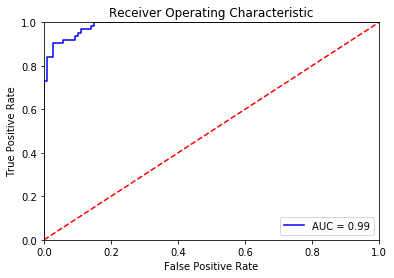

In [24]:
# Plot the AUC-ROC curve
fpr, tpr, threshold = metrics.roc_curve(results["true"], results["pred_1"])
roc_auc = metrics.auc(fpr, tpr)

plt.title("Receiver Operating Characteristic")
plt.plot(fpr, tpr, "b", label="AUC = %0.2f" % roc_auc)
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], "r--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.show()

## Closing

In this notebook we used SageMaker script mode to build, train, and deploy a sklearn model.
Also, we used SageMaker Data Wrangler for feature engineering.